
### Use it for random-global failure and recovery

### number of nodes to remove = 65 (for flood)



In [26]:
import pandas as pd
import numpy as np
import yaml
import copy
import matplotlib
import matplotlib.pyplot as plt
import warnings
import random
import collections
warnings.filterwarnings("ignore")
matplotlib.use('TkAgg')
import networkx as nx
%matplotlib inline

In [27]:
pwd

'/Users/nishant/Desktop/PNNL-2019/Topology_Based_Failure'

In [28]:
def import_network(path):
    """
    path = path to network data
    df = imported network data as a pandas dataframe
    """
    
    df = pd.read_csv(path, sep=" ", 
                 header=None,
                 names=['layer','node1','node2','weight'])
    
    return df


def create_edge_list(df, n_layers):
    
    edges = []
    for i in range(n_layers):
        edges.append(list(zip(df["node1"][df.layer==i+1], df["node2"][df.layer==i+1])))
    
    return edges

def create_node_list(df, which_layer):
    
    temp = list(set(df.node1[df.layer==which_layer]))
    temp2 = list(set(df.node2[df.layer==which_layer]))
    node_list = list(set(temp+temp2))
    
    return node_list


def calculate_gc_size(graph):
    """
    gc = giant component
    """
    
    gc_size = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)][0]
    
    return gc_size


def normalize_gc_list(gc_list):
    "calculates gc size as a fraction of initial gc"
    
    return np.array(gc_list)/max(gc_list)



In [29]:
if __name__ == "__main__":
    
    config_file = '/Users/nishant/Desktop/PNNL-2019/config.yml'
    
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
        path = config['path']
        n_layers = config['n_layers']
        df = import_network(path)
        edge_list = create_edge_list(df, n_layers)
    

In [30]:
"""CREATE EDGE LIST"""

edge_list_1 = edge_list[0]
edge_list_2 = edge_list[1]
edge_list_3 = edge_list[2]

agg_edges = list(set(edge_list_1 + edge_list_2 + edge_list_3))

print(len(edge_list_1))
print(len(edge_list_2))
print(len(edge_list_3))
print(len(agg_edges))

312
83
46
430


In [31]:
"""CREATE NODE LISTS"""

node_list_1 = create_node_list(df, 1)
node_list_2 = create_node_list(df, 2)
node_list_3 = create_node_list(df, 3)

print(len(node_list_1))
print(len(node_list_2))
print(len(node_list_3))

271
83
45


In [32]:
# def create_mplex(e_1, e_2, e_3, n_1, n_2, n_3):
    
#     t_nodes = 369 #total distinct nodes
    
#     node_list_mplex = list(np.hstack((np.array(n_1), (np.array(n_2) + t_nodes), 
#                                     np.array(n_3)+2*t_nodes)))
    
#     edge_list_1_mplex = np.array(e_1)
#     edge_list_2_mplex = np.array(e_2) + 369
#     edge_list_3_mplex = np.array(e_3) + 2*369
    
#     G = nx.Graph()
    
#     """Add Edges"""
    
#     G.add_edges_from(edge_list_1_mplex)
#     G.add_edges_from(edge_list_2_mplex)
#     G.add_edges_from(edge_list_3_mplex)
    
#     """Add Intralayer Edges"""
    
#     intra_layer_edges = []

#     for node in n_1:
#         if node in n_2:
#             intra_layer_edges.append((node,node+ t_nodes))
#         if node in n_3:
#             intra_layer_edges.append((node,node+ 2*t_nodes))
        
#     for node2 in n_2:
#         if node2 in n_3:
#             intra_layer_edges.append((node2 + t_nodes, node2 + 2*t_nodes))
    
#     G.add_edges_from(intra_layer_edges)
    
#     return G
    

In [33]:
G1 = nx.Graph()
G1.add_edges_from(edge_list_1)

G2 = nx.Graph()
G2.add_edges_from(edge_list_2)

G3 = nx.Graph()
G3.add_edges_from(edge_list_3)

agg_G = nx.Graph()
agg_G.add_edges_from(agg_edges)

#mplex_G = create_mplex(edge_list_1, edge_list_2, edge_list_3, node_list_1, node_list_2, node_list_3)

In [34]:
"""PICK THE GRAPH TO ANALYZE """

which_graph = 4

"""
which_graph:

1: layer 1 (underground)
2: layer 2 (overground)
3: layer 3 (DLR)
4: Aggregated 
5: Mplex (not working here)

"""


if which_graph == 1:
    G = G1
    node_list = node_list_1

elif which_graph == 2:
    G = G2
    node_list = node_list_2
    
elif which_graph == 3:
    G = G3
    node_list = node_list_3
    
elif which_graph == 4:
    G = agg_G
    node_list = list(G.nodes())
    
elif which_graph == 5:
    G = mplex_G
    node_list = list(G.nodes())


edge_list = list(G.edges)

print('Nodes: ', len(node_list))
print('Edges: ', len(edge_list))

Nodes:  369
Edges:  430


In [35]:
"""
calculate initial giant component (gc) size
"""

initial_gc_size = calculate_gc_size(G)
print(initial_gc_size)


369


In [40]:
"""Create Ensemble Lists of Nodes to Remove for Random Failure"""

node_list = list(G.nodes())
node_list_copy = copy.deepcopy(node_list)

#n_nodes_to_remove = len(node_list)
n_nodes_to_remove = 65

sorted_nodes_by_random = []

for i in range(100):
    sorted_nodes_by_random.append(random.sample(node_list_copy, n_nodes_to_remove))


print(len(sorted_nodes_by_random[0]))
print(len(sorted_nodes_by_random))

65
100


## FAILURE PART OF THE PLOT

In [41]:
def remove_nodes(G, nodes_to_remove, edge_list):

    """
    nodes_to_remove: list

    edge_list: for this layer the orginal list of tuples (edges)
                e.g. [(1,77), (4,13)..]

    returns list of GC sizes and the graph remaining 
    """

    
    """initialize updated_edges list with original edge_list"""
    updated_edges = copy.deepcopy(edge_list)
    
    """initialize updated_G with orginial graph G"""
    updated_G = copy.deepcopy(G)
    initial_gc_size = calculate_gc_size(G)
    
    """empty list which will capture gc size as the network fails"""
    gc_list = []
    gc_list.append(initial_gc_size)
    count = 0

    for node in nodes_to_remove:
        
        updated_G.remove_edges_from(list(G.edges(node)))
        
        gc_list.append(calculate_gc_size(updated_G))
        updated_G.remove_node(node)
    
        count +=1
    
    #else:
    if len(nodes_to_remove) == len(node_list):
        gc_list.append(0)
    
    return gc_list, updated_G, count


In [42]:
"""RANDOM FAILURE"""

gc_list_by_random = []
updated_G_list = []

for i in range(100):
    nodes_to_remove = sorted_nodes_by_random[i]
    gc_temp, updated_G_temp, count = remove_nodes(G, nodes_to_remove, edge_list)
    gc_list_by_random.append(normalize_gc_list(gc_temp))
    updated_G_list.append(updated_G_temp)

print(len(gc_list_by_random[0]))

66


In [43]:
gc_list_by_random[0]

array([1.        , 0.99728997, 0.98915989, 0.98644986, 0.96476965,
       0.96205962, 0.95934959, 0.95663957, 0.95392954, 0.95121951,
       0.94579946, 0.92682927, 0.92411924, 0.91598916, 0.91327913,
       0.89701897, 0.89430894, 0.89159892, 0.86720867, 0.78861789,
       0.7804878 , 0.76693767, 0.76422764, 0.73712737, 0.73441734,
       0.73170732, 0.72357724, 0.72086721, 0.71815718, 0.7100271 ,
       0.69647696, 0.67208672, 0.65853659, 0.65582656, 0.65311653,
       0.6504065 , 0.62059621, 0.61788618, 0.61517615, 0.61246612,
       0.6097561 , 0.57181572, 0.57181572, 0.56639566, 0.56368564,
       0.56097561, 0.55826558, 0.55826558, 0.55555556, 0.55555556,
       0.5501355 , 0.5501355 , 0.54200542, 0.54200542, 0.53658537,
       0.53658537, 0.53387534, 0.53116531, 0.53116531, 0.52303523,
       0.5203252 , 0.51490515, 0.49864499, 0.49593496, 0.48238482,
       0.48238482])

## RECOVERY PART OF THE PLOT

In [44]:
def add_nodes(G, updated_G, nodes_to_add, edge_list):
    
    """re: recovery
    """
    
    """initialize the graph object with the graph (updated_G) remaining post failure"""
    re_updated_G = copy.deepcopy(updated_G)
    edges_to_add = copy.deepcopy(edge_list)
     
    """empty list which will capture gc size as the network recovers"""
    re_gc_list = []
    count = 0
    initial_gc_size = calculate_gc_size(G)
    
    if len(nodes_to_remove) == len(node_list):
        re_gc_list.append(0)
    
    for node in nodes_to_add:
        
        re_updated_G.add_node(node)
        re_updated_G.add_edges_from(list(G.edges(node)))
        re_gc_list.append(calculate_gc_size(re_updated_G))
    
    
    re_gc_list.append(initial_gc_size)
    
    return re_gc_list, re_updated_G, count


In [46]:
"""RECOVERY - Nodes to Add"""

re_gc_list_by_random = []
re_updated_G_list = []

for i in range(100):
    nodes_to_add = sorted_nodes_by_random[i]
    re_gc_temp, re_updated_G_temp, count = add_nodes(G, updated_G_list[i], nodes_to_add, edge_list)
    re_gc_list_by_random.append(normalize_gc_list(re_gc_temp))
    re_updated_G_list.append(updated_G_temp)

print(len(re_gc_list_by_random[0]))

66


In [47]:
re_gc_list_by_random[0]

array([0.48780488, 0.49593496, 0.49593496, 0.50677507, 0.51761518,
       0.52303523, 0.52574526, 0.52574526, 0.53116531, 0.53116531,
       0.5501355 , 0.55555556, 0.63143631, 0.63414634, 0.63414634,
       0.63685637, 0.6395664 , 0.66395664, 0.68563686, 0.68563686,
       0.69105691, 0.69376694, 0.69376694, 0.69647696, 0.69647696,
       0.69918699, 0.7100271 , 0.71273713, 0.71815718, 0.71815718,
       0.75880759, 0.75880759, 0.75880759, 0.76151762, 0.76422764,
       0.78319783, 0.78590786, 0.78590786, 0.78861789, 0.78861789,
       0.8401084 , 0.84281843, 0.87533875, 0.87804878, 0.88075881,
       0.88346883, 0.88346883, 0.90243902, 0.91056911, 0.91598916,
       0.91869919, 0.92682927, 0.92682927, 0.92682927, 0.93224932,
       0.93495935, 0.93766938, 0.94308943, 0.96205962, 0.96476965,
       0.96747967, 0.98644986, 0.98915989, 0.98915989, 1.        ,
       1.        ])

In [48]:
"""Calculate Ensemble Mean - Random Failure"""

gc_list_by_random = np.array(gc_list_by_random)
re_gc_list_by_random = np.array(re_gc_list_by_random)

gc_list_by_random_mean = np.mean(gc_list_by_random, axis=0)
re_gc_list_by_random_mean = np.mean(re_gc_list_by_random, axis=0)



In [49]:
"""Save GC size List of Lists"""

# np.save('l2_gc_list_by_random', gc_list_by_random)
# np.save('l2_re_gc_list_by_random', re_gc_list_by_random)


"""Save Ensemble Mean (a single list)"""

#np.save('l3_gc_list_by_random', gc_list_by_random_mean)
#np.save('l3_re_gc_list_by_random', re_gc_list_by_random_mean)

'Save Ensemble Mean (a single list)'

In [50]:
pwd

'/Users/nishant/Desktop/PNNL-2019/Topology_Based_Failure'

## PLOTTING

In [51]:
"""fraction of nodes removed on x-axis"""

node_frac = np.arange(len(gc_list_by_random[0])) 

print(len(node_frac))

66


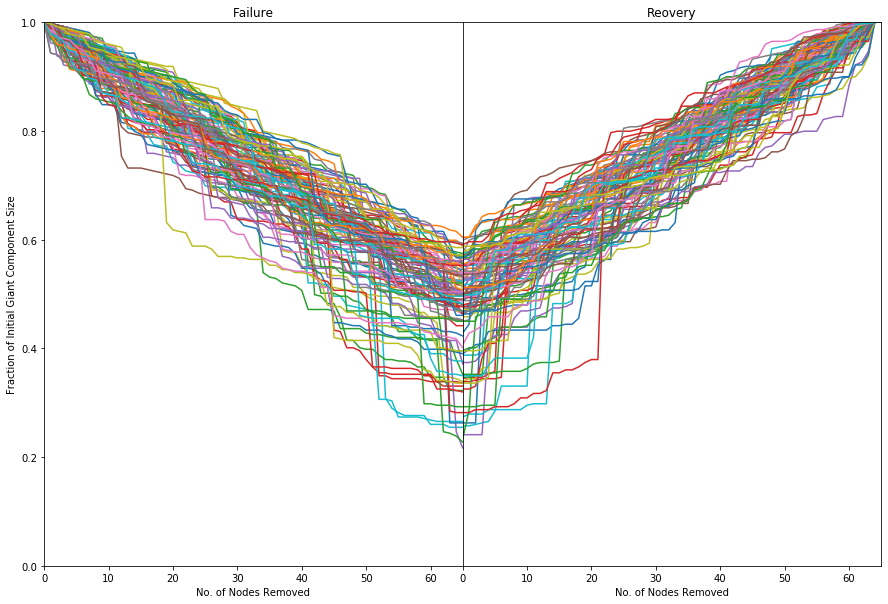

In [52]:
plt.figure(figsize=(15,10))

for i in range(100):
    
    plt.subplot(1,2,1)
    plt.plot(node_frac, gc_list_by_random[i], label='')
    
    plt.ylim(top=1, bottom=0)
    #plt.xlim(left=0, right=1)
    plt.xlabel('No. of Nodes Removed')
    plt.ylabel('Fraction of Initial Giant Component Size')
    plt.title('Failure')
    plt.margins(x=0, y=0)
    #plt.legend()

    plt.subplot(1,2,2)
    plt.plot(node_frac,re_gc_list_by_random[i], label='')

    #plt.plot(node_frac, node_frac, '--')
    #plt.xlim(left=0)
    plt.ylim(bottom=0, top=1)
    plt.yticks([])
    #plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel('No. of Nodes Removed')
    plt.title('Reovery')
    plt.margins(x=0, y=0)
    #plt.legend()
 

plt.subplots_adjust(wspace=0)
#plt.suptitle('Random Failure (Ensemble N=1000)', y=0.92, fontsize='16')
plt.show()


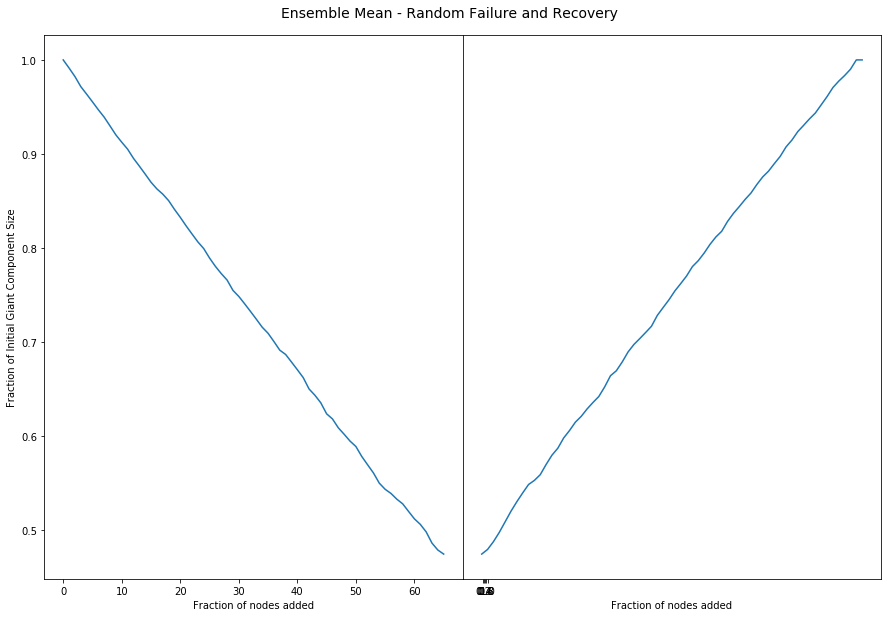

In [53]:
"""Plot Ensemble Mean"""

plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.plot(node_frac, gc_list_by_random_mean, '-', label='#degree')
#plt.ylim(top=1, bottom=0)
#plt.xlim(left=0, right=1)
plt.xlabel('Fraction of nodes added')
plt.ylabel('Fraction of Initial Giant Component Size')
    #plt.legend()

plt.subplot(1,2,2)
plt.plot(node_frac,re_gc_list_by_random_mean, label='#degree')
    #plt.plot(node_frac, node_frac, '--')
#plt.xlim(left=0, right=1)
#plt.ylim(bottom=0, top=1)
plt.yticks([])
plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
plt.xlabel('Fraction of nodes added')
    #plt.legend()
plt.subplots_adjust(wspace=0)

plt.suptitle('Ensemble Mean - Random Failure and Recovery', y=0.92, fontsize='14')
plt.show()